In [1]:
%pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 21.1 MB/s  0:00:00m0:00:0100:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


Current working directory: /Users/harshilarora/Documents/Car-Damage-Detection-Model/Middleware/models/stage1/metrics
Loading model...
Model loaded.
Accuracy: 0.8314
Unique true labels: {0, 1}
Dataset size: 6697

Classification Report:

              precision    recall  f1-score   support

       clean       0.93      0.77      0.84      3881
     damaged       0.74      0.92      0.82      2816

    accuracy                           0.83      6697
   macro avg       0.84      0.84      0.83      6697
weighted avg       0.85      0.83      0.83      6697



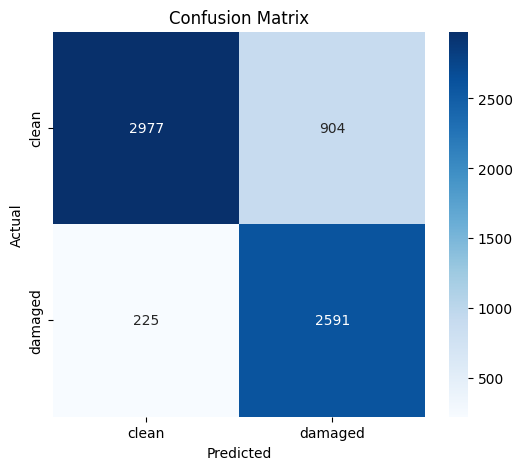

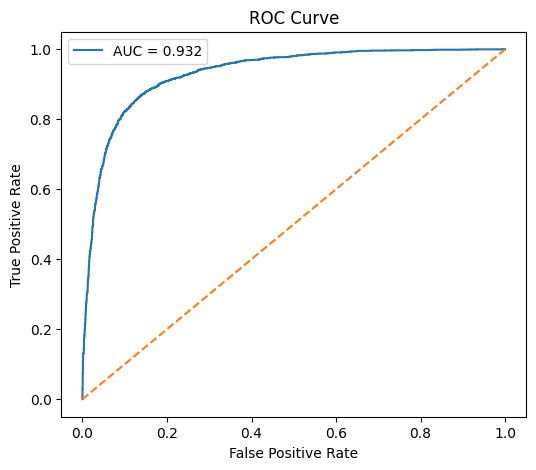

In [9]:
# -----------------------------------------
# 1. IMPORTS & SETUP
# -----------------------------------------

import os
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
import keras
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# 2. CONFIG
# -----------------------------------------
IMG_SIZE = (224, 224)
THRESHOLD = 0.82
MODEL_PATH = "../../../models/stage1/models/mobilenetv3_canny_final.keras"
print("Current working directory:", os.getcwd())

print("Loading model...")
model = keras.models.load_model(MODEL_PATH)
print("Model loaded.")

# -----------------------------------------
# 3. PREPROCESSING
# -----------------------------------------
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(IMG_SIZE)

    img_rgb = np.array(image, dtype=np.uint8)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 120)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    img_rgb = img_rgb.astype(np.float32) / 255.0
    edges = edges.astype(np.float32) / 255.0

    return np.expand_dims(img_rgb, axis=0), np.expand_dims(edges, axis=0)

# -----------------------------------------
# 4. SINGLE PREDICTION
# -----------------------------------------
def predict_single(image_path):
    rgb, ed = preprocess_image(image_path)
    prob = float(model.predict([rgb, ed], verbose=0)[0][0])
    return prob

# -----------------------------------------
# 5. LOAD DATASET
# -----------------------------------------
def load_dataset(base_folder):
    damaged_dir = os.path.join(base_folder, "CarDD_COCO/train")
    clean_dir   = os.path.join(base_folder, "CarDD_COCO/clean_cars")

    image_paths = []
    labels = []

    for directory, label in [(clean_dir, 0), (damaged_dir, 1)]:
        if not os.path.exists(directory):
            print("Missing folder:", directory)
            continue

        for f in os.listdir(directory):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(directory, f))
                labels.append(label)

    return image_paths, labels

# -----------------------------------------
# 6. RUN PREDICTIONS ON FOLDER
# -----------------------------------------
DATASET_DIR = "../../../dataset/"  # update path as needed

image_paths, true_labels = load_dataset(DATASET_DIR)

pred_probs = []
pred_labels = []

for img in image_paths:
    prob = predict_single(img)
    pred_probs.append(prob)
    pred_labels.append(1 if prob > THRESHOLD else 0)

# -----------------------------------------
# 7. ACCURACY
# -----------------------------------------
accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy:", round(accuracy, 4))

# -----------------------------------------
print("Unique true labels:", set(true_labels))
print("Dataset size:", len(true_labels))

# 8. CLASSIFICATION REPORT
# -----------------------------------------
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=["clean", "damaged"]))

# -----------------------------------------
# 9. CONFUSION MATRIX
# -----------------------------------------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["clean", "damaged"],
    yticklabels=["clean", "damaged"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -----------------------------------------
# 10. ROC CURVE
# -----------------------------------------
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
